In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/covid19-global-forecasting-week-4/train.csv
/kaggle/input/covid19-global-forecasting-week-4/submission.csv
/kaggle/input/covid19-global-forecasting-week-4/test.csv


### Simple EDA

In [2]:
covid19_train_df = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/train.csv')

In [3]:
covid19_train_df.describe()

,Id,ConfirmedCases,Fatalities
count,25353.000000,25353.000000,25353.000000
mean,17825.000000,1003.824518,50.392853
std,10300.683266,7542.589521,592.843013
min,1.000000,0.000000,0.000000
25%,8913.000000,0.000000,0.000000
50%,17825.000000,1.000000,0.000000
75%,26737.000000,93.000000,1.000000
max,35649.000000,181026.000000,19468.000000


In [4]:
covid19_train_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [5]:
covid19_train_df.sample()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
17571,24700,NaN,Singapore,2020-04-06,1375.0,6.0


In [6]:
covid19_train_df.sample(n=10)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
10295,14487,NaN,Germany,2020-01-30,4.0,0.0
11661,16381,NaN,Iraq,2020-04-09,1232.0,69.0
4312,6062,NaN,Chile,2020-02-10,0.0,0.0
24384,34318,Isle of Man,United Kingdom,2020-01-25,0.0,0.0
14674,20648,NaN,Nepal,2020-02-04,1.0,0.0
16196,22764,NaN,Philippines,2020-04-08,3870.0,182.0
8013,11248,NaN,Denmark,2020-04-06,4681.0,187.0
10550,14841,NaN,Grenada,2020-02-11,0.0,0.0
12022,16907,NaN,Japan,2020-02-25,170.0,1.0
13046,18360,NaN,Liechtenstein,2020-01-27,0.0,0.0


### Simple Data Visualization

In [7]:
import seaborn as sns

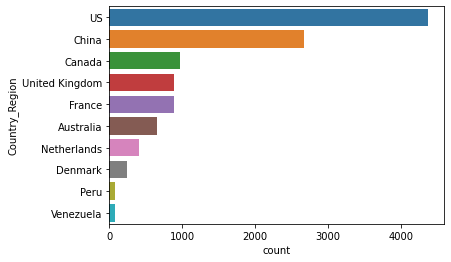

In [8]:
sns.countplot(y="Country_Region", data=covid19_train_df,order=covid19_train_df["Country_Region"].value_counts(ascending=False).iloc[:10].index)

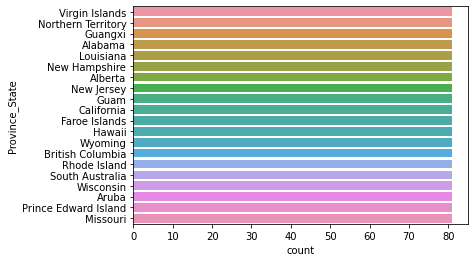

In [9]:
sns.countplot(y="Province_State", data=covid19_train_df,order=covid19_train_df["Province_State"].value_counts(ascending=False).iloc[:20].index)

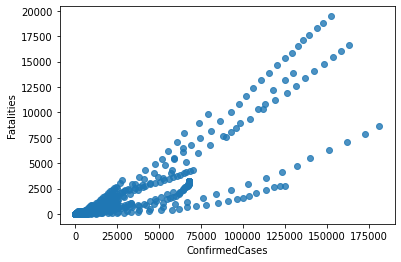

In [10]:
sns.regplot(x=covid19_train_df["ConfirmedCases"], y=covid19_train_df["Fatalities"], fit_reg=False)

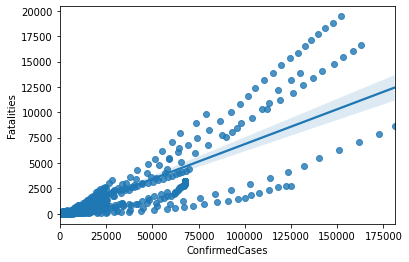

In [11]:
sns.regplot(x=covid19_train_df["ConfirmedCases"], y=covid19_train_df["Fatalities"])

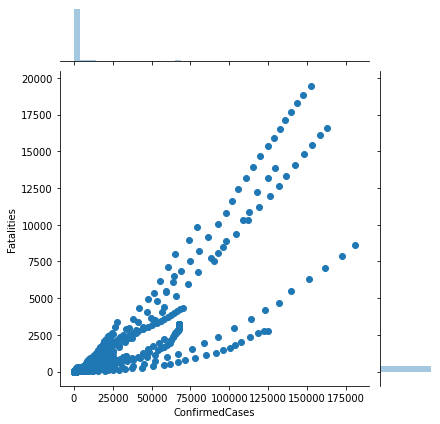

In [12]:
sns.jointplot(x=covid19_train_df["ConfirmedCases"], y=covid19_train_df["Fatalities"], kind='scatter')

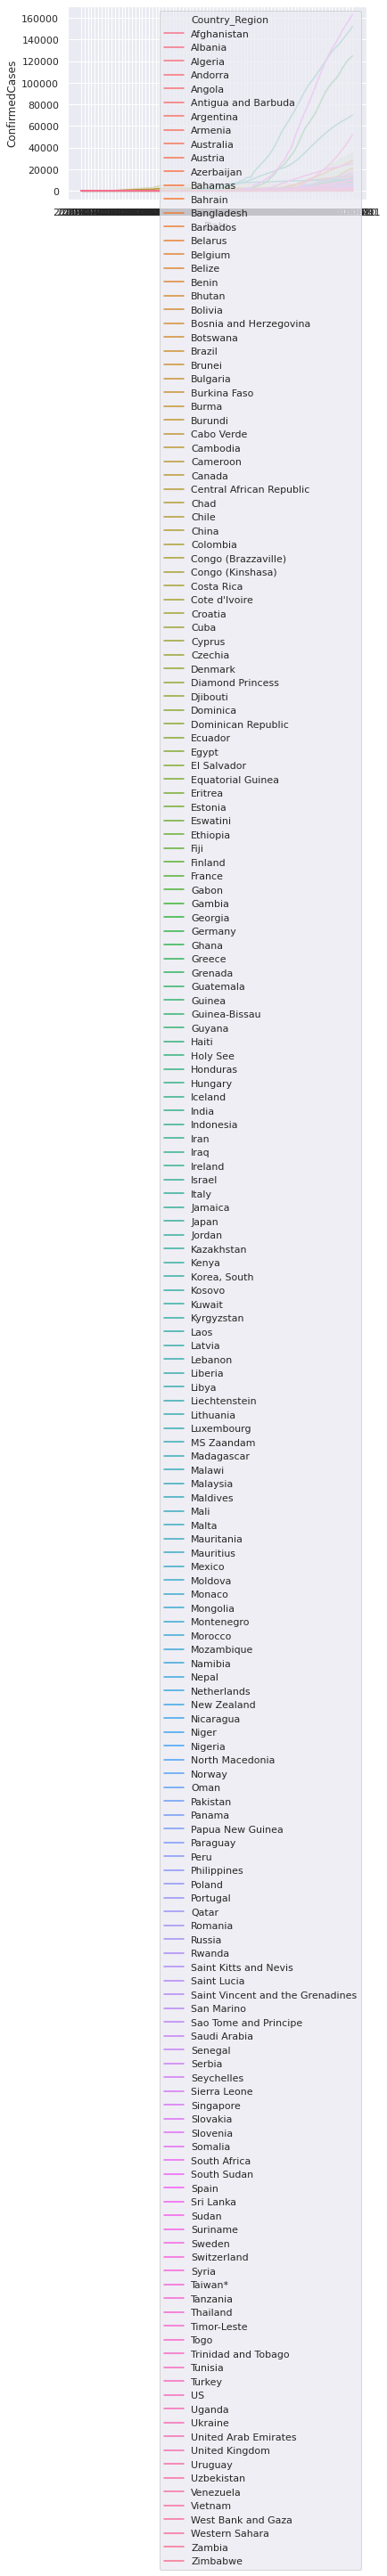

In [13]:
sns.set(style="darkgrid")
sns.lineplot(x="Date",y="ConfirmedCases",hue="Country_Region", 
             data=covid19_train_df)

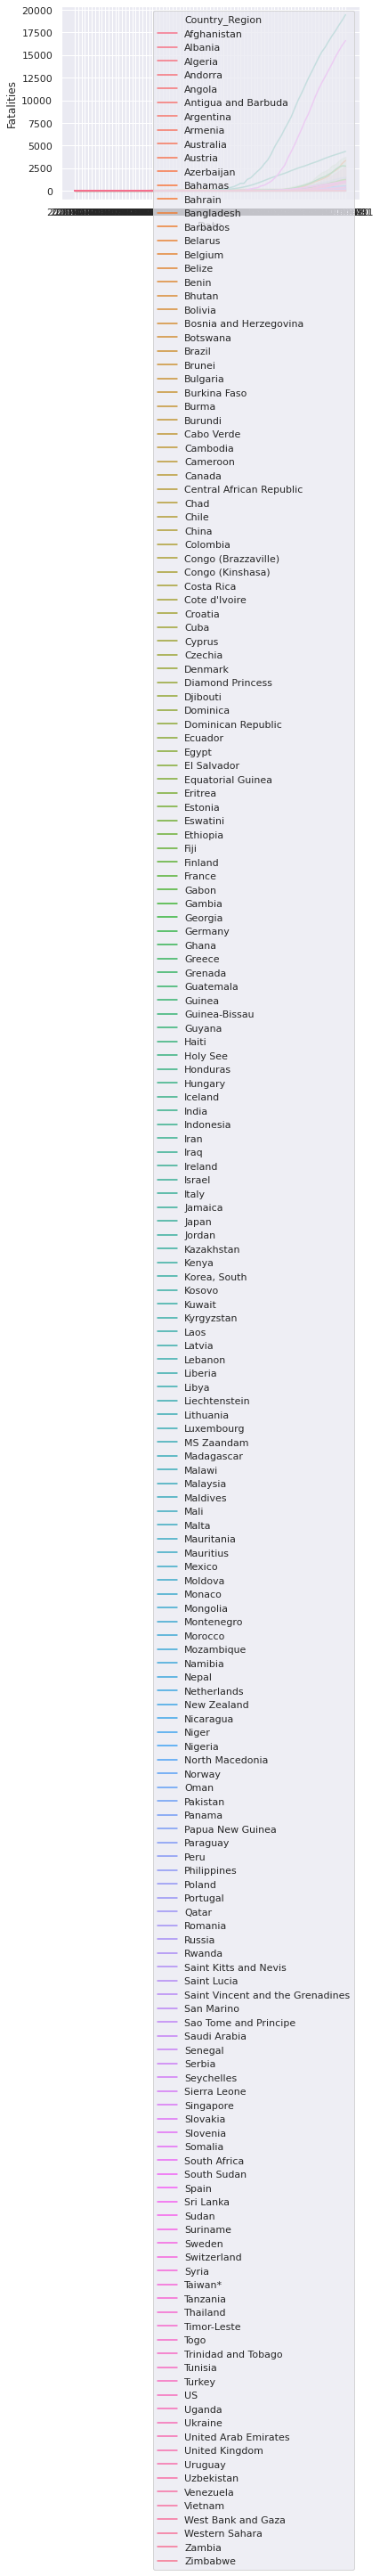

In [14]:
sns.set(style="darkgrid")
sns.lineplot(x="Date",y="Fatalities", hue="Country_Region",
             data=covid19_train_df)

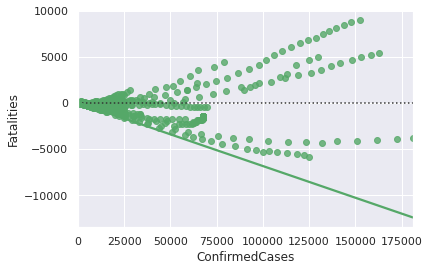

In [15]:
sns.residplot(x=covid19_train_df["ConfirmedCases"], y=covid19_train_df["Fatalities"], lowess=True, color="g")

In [16]:
#data_4.to_csv("submission.csv", index=False)

### XGB Boost 

In [17]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [18]:
trainData = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/train.csv')
testData = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/test.csv')

print(trainData.shape)
print(testData.shape)


(25353, 6)
(13459, 4)


In [19]:
convertDict = {'Province_State': str,'Country_Region':str}
trainData = trainData.astype(convertDict)
testData = testData.astype(convertDict)

In [20]:


trainData['Date'] = pd.to_datetime(trainData['Date'], infer_datetime_format=True)

testData['Date'] = pd.to_datetime(testData['Date'], infer_datetime_format=True)

In [21]:

trainData.loc[:, 'Date'] = trainData.Date.dt.strftime('%m%d')
trainData.loc[:, 'Date'] = trainData['Date'].astype(int)


testData.loc[:, 'Date'] = testData.Date.dt.strftime('%m%d')
testData.loc[:, 'Date'] = testData['Date'].astype(int)

In [22]:
trainData['Country_Region'] = np.where(trainData['Province_State'] == 'nan',
                                       trainData['Country_Region'],trainData['Province_State']+
                                       trainData['Country_Region'])
testData['Country_Region'] = np.where(testData['Province_State'] == 'nan',
                                      testData['Country_Region'],testData['Province_State']+
                                      testData['Country_Region'])

In [23]:
trainData = trainData.drop(columns=['Province_State'])
testData = testData.drop(columns=['Province_State'])

print(trainData.head(),testData.head())
print(trainData.shape,testData.shape)

   Id Country_Region  Date  ConfirmedCases  Fatalities
0   1    Afghanistan   122             0.0         0.0
1   2    Afghanistan   123             0.0         0.0
2   3    Afghanistan   124             0.0         0.0
3   4    Afghanistan   125             0.0         0.0
4   5    Afghanistan   126             0.0         0.0    ForecastId Country_Region  Date
0           1    Afghanistan   402
1           2    Afghanistan   403
2           3    Afghanistan   404
3           4    Afghanistan   405
4           5    Afghanistan   406
(25353, 5) (13459, 3)


In [24]:
#list of categorical variables
categoryObject = (trainData.dtypes == 'object')
objectData = list(categoryObject[categoryObject].index)

In [25]:
objectData

['Country_Region']

In [26]:
labelEncoder = LabelEncoder()
trainData['Country_Region'] = labelEncoder.fit_transform(trainData['Country_Region'])
testData['Country_Region'] = labelEncoder.transform(testData['Country_Region'])

In [27]:
trainData.head()

,Id,Country_Region,Date,ConfirmedCases,Fatalities
0,1,0,122,0.0,0.0
1,2,0,123,0.0,0.0
2,3,0,124,0.0,0.0
3,4,0,125,0.0,0.0
4,5,0,126,0.0,0.0


In [28]:
testData.head()

,ForecastId,Country_Region,Date
0,1,0,402
1,2,0,403
2,3,0,404
3,4,0,405
4,5,0,406


In [29]:
testForecastId = testData.ForecastId

In [30]:
trainData.drop(['Id'], axis=1, inplace=True)
testData.drop('ForecastId', axis=1, inplace=True)

In [31]:
trainData.head(), trainData.shape

(   Country_Region  Date  ConfirmedCases  Fatalities
 0               0   122             0.0         0.0
 1               0   123             0.0         0.0
 2               0   124             0.0         0.0
 3               0   125             0.0         0.0
 4               0   126             0.0         0.0,
 (25353, 4))

In [32]:
testData.head(), testData.shape

(   Country_Region  Date
 0               0   402
 1               0   403
 2               0   404
 3               0   405
 4               0   406,
 (13459, 2))

In [33]:
#pip install pandas-profiling

In [34]:
import pandas_profiling

#### train data EDA using pandas profiling

In [35]:
trainData.profile_report()

#### test data profile report

In [36]:
testData.profile_report()

In [37]:
from xgboost import XGBRegressor

In [38]:
X_train = trainData[['Country_Region','Date']]
y_train = trainData[['ConfirmedCases', 'Fatalities']]

In [39]:
x_train = X_train.iloc[:,:].values
x_test = testData.iloc[:,:].values

In [40]:
model = MultiOutputRegressor(XGBRegressor(n_estimators=1500, max_depth=20, random_state=0))
model.fit(x_train, y_train)
predict = MultiOutputRegressor(model.predict(x_test))

In [41]:
submissionData = pd.DataFrame()
submissionData['ForecastId'] = testForecastId
submissionData['ConfirmedCases'] = np.round(predict.estimator[:,0],2)
submissionData['Fatalities'] = np.round(predict.estimator[:,1],2)

submissionData.to_csv('submission.csv', index=False)

In [42]:
submissionData.sample(5), submissionData.shape

(       ForecastId  ConfirmedCases  Fatalities
 11473       11474          2702.0       102.0
 7664         7665          1545.0       111.0
 1945         1946           428.0         2.0
 11087       11088           616.0        19.0
 689           690         11524.0       168.0,
 (13459, 3))